# [Private 1위] Model Ensembling
두 가지 접근 방법으로 얻은 모델 결과를 종합했습니다.

a. Text classification models (e.g., bert)
- class imbalance 문제 해결하기 위해 first party와 second party의 순서를 바꾸는 data augmentation 방법 적용.
- pretrained weights 부분은 모두 freeze 한 뒤 추가되는 residual connection이 적용된 네트워크 직접 설계.
- 텍스트 분류 모델 중 4가지 모델 활용.

b. Large language models (e.g., vicuna-13b)
- 예측해야 하는 테스트 데이터와 유사한 판결 사례들을 함께 활용하여 예측하는 few-shot learning 접근 방법 활용.
- ALBERT 기반 판결 내용을 하나의 embedding vector로 압축하여 유사한 판결 사례들을 cosine similarity 계산하여 선별.
- 언어 모델 중 Vicuna-13B 활용.

c. 결론: Private score 0.57258 달성. Overview 관련 아래 그림 참고.

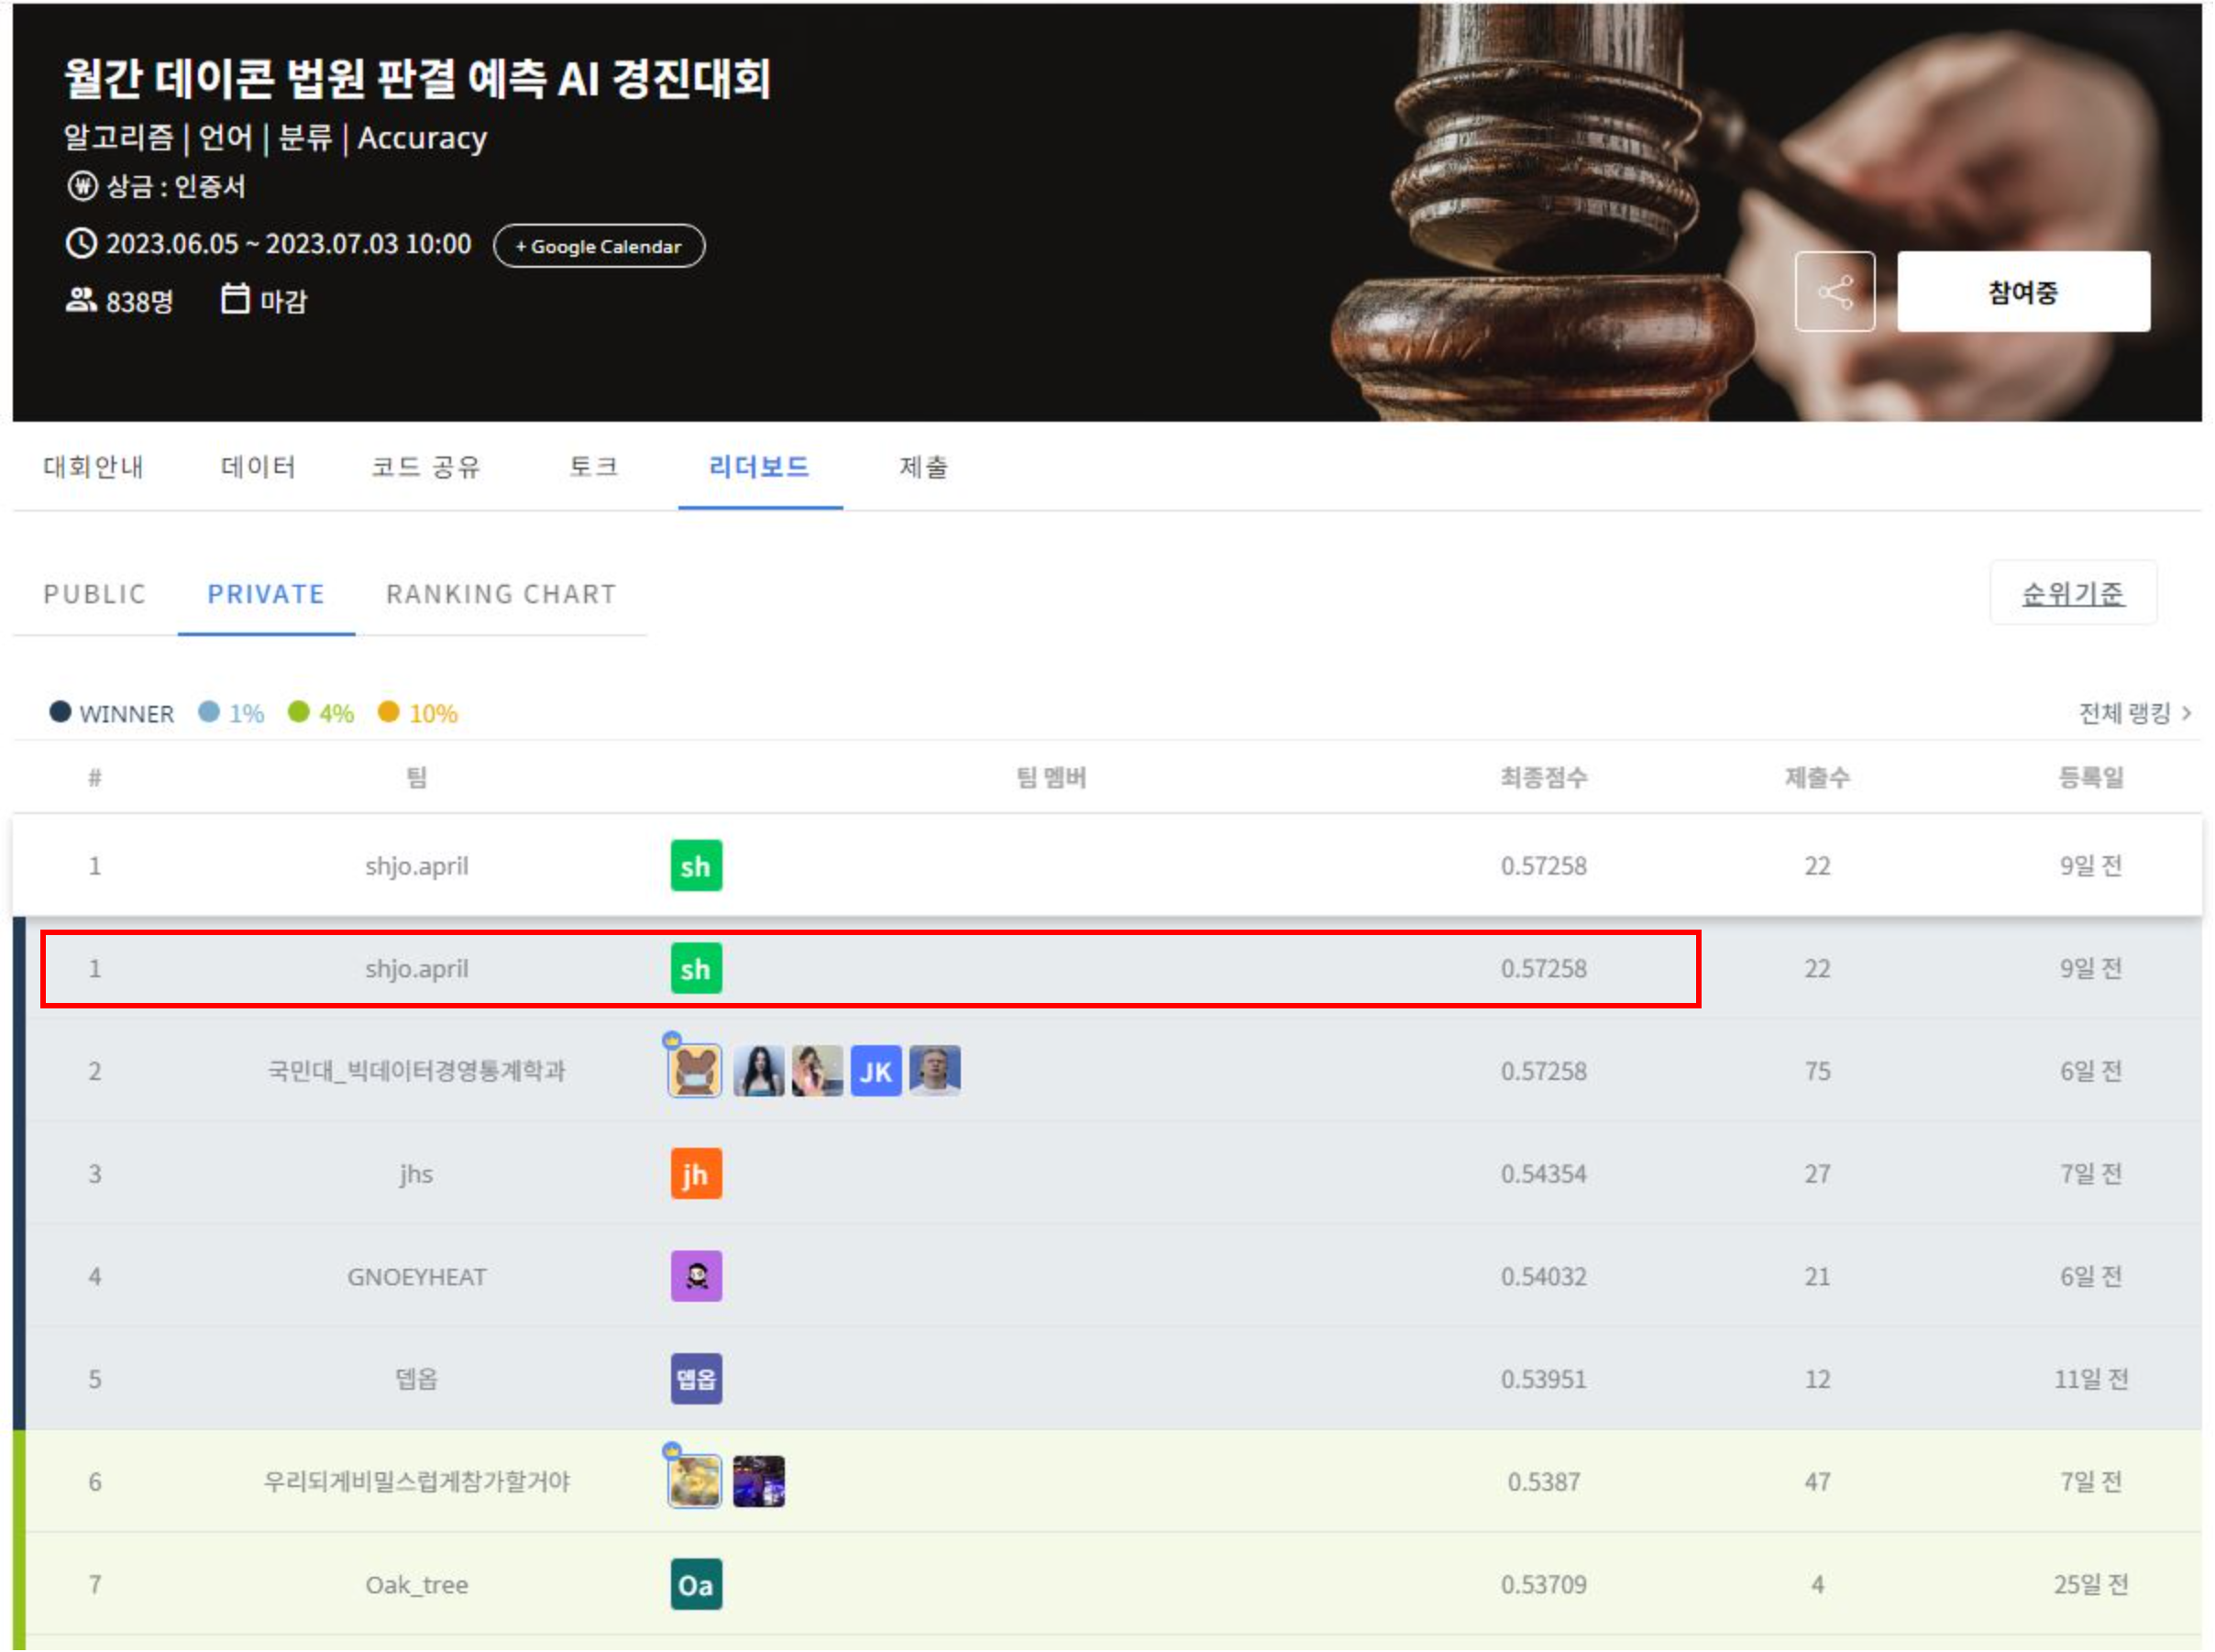

In [2]:
from IPython import display
display.Image("./figures/ranking.png")

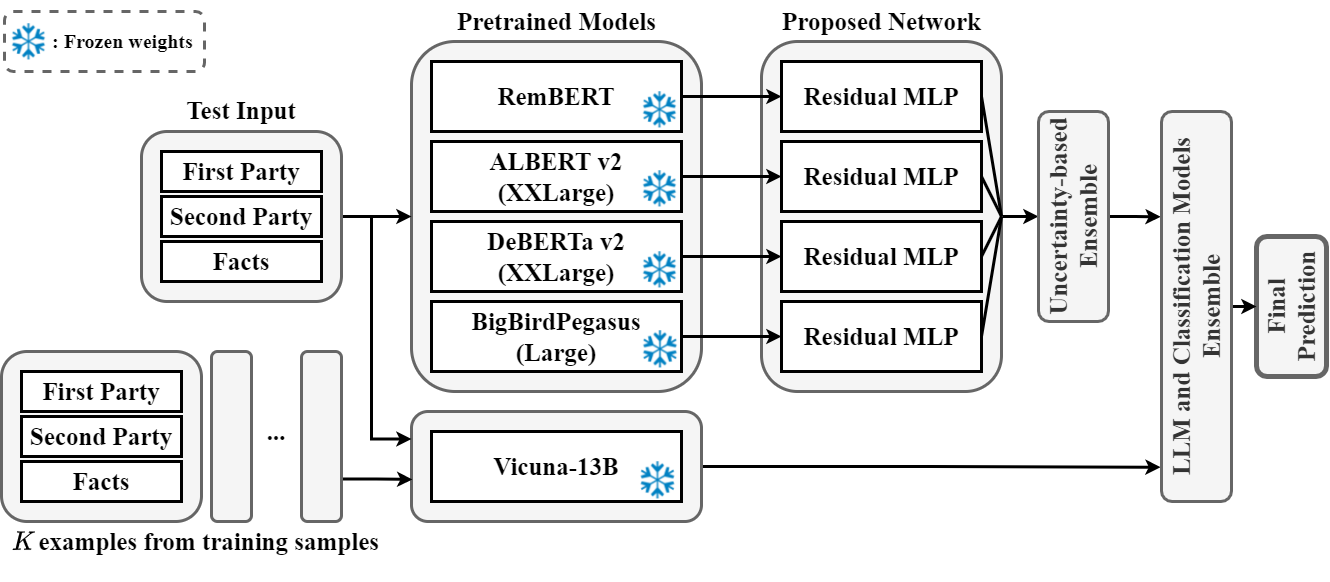

In [3]:
display.Image("./figures/overview.png")

# 1. Reproducibility
- 하드웨어 스펙: A6000 x 1, RAM 252GB

- 공정한 검정을 위해 사전 학습된 모델 파일들은 Google Drive 링크로 참조하시면 됩니다. (https://drive.google.com/file/d/1B_litWreHZnkRN4VZrOCczbgePl4Szxb/view?usp=sharing)
- 하나의 코드 파일로 정리할 수 있지만, 너무 길어질 것 같아 github으로 정리했습니다. (https://github.com/shjo-april/DACON_Judgement_of_Court_1st_Solution)
- 핵심 코드 및 실행 방법은 아래 순서 참조하시면 됩니다.

- 첫번째, text classification models 관련 환경 설정 및 테스트 방법입니다.
- venv 활용하였고, 명령어는 아래와 같습니다.
```bash
python3 -m venv venv
source ./venv/bin/activate
pip install -r requirements.txt
```

- 학습 및 테스트 데이터 전처리.
```bash
python3 preprocess.py
```

- 학습 데이터에 대한 embedding vectors 추출
```bash
CUDA_VISIBLE_DEVICES=0 python3 extract_embs_for_trainval.py --model google/bigbird-pegasus-large-bigpatent --tag bigbird-pegasus-large-bigpatent
CUDA_VISIBLE_DEVICES=0 python3 extract_embs_for_trainval.py --model google/rembert --tag rembert
CUDA_VISIBLE_DEVICES=0 python3 extract_embs_for_trainval.py --model microsoft/deberta-v2-xxlarge --tag deberta-v2-xxlarge
CUDA_VISIBLE_DEVICES=0 python3 extract_embs_for_trainval.py --model albert-xxlarge-v2 --tag albert-xxlarge-v2
```

- 테스트 데이터에 대한 embedding vectors 추출
```bash
CUDA_VISIBLE_DEVICES=0 python3 extract_embs_for_test.py --model google/bigbird-pegasus-large-bigpatent --tag bigbird-pegasus-large-bigpatent
CUDA_VISIBLE_DEVICES=0 python3 extract_embs_for_test.py --model google/rembert --tag rembert
CUDA_VISIBLE_DEVICES=0 python3 extract_embs_for_test.py --model microsoft/deberta-v2-xxlarge --tag deberta-v2-xxlarge
CUDA_VISIBLE_DEVICES=0 python3 extract_embs_for_test.py --model albert-xxlarge-v2 --tag albert-xxlarge-v2
```

- 언어 모델용 데이터 전처리
```bash
CUDA_VISIBLE_DEVICES=0 python3 extract_embs_for_llm.py --file ./open/train.json
CUDA_VISIBLE_DEVICES=1 python3 extract_embs_for_llm.py --file ./open/test.json
python3 generate_qa_list_for_llm.py
```

- 사전 학습된 모델 기반 1차 예측 결과 생성
```bash
CUDA_VISIBLE_DEVICES=0 python3 infer_classification_models.py --model_names rembert,albert-xxlarge-v2,deberta-v2-xxlarge,bigbird-pegasus-large-bigpatent
```

- 두번째, large language models 관련 환경 설정 및 테스트 방법입니다.
```bash
deactivate
cd llm
python3 -m venv venv
source ./venv/bin/activate
pip3 install --upgrade pip
pip3 install -e .
git lfs install
git clone https://huggingface.co/lmsys/vicuna-13b-v1.3
```

- Vicuna-13B 기반 테스트 셋에 대한 2차 예측 결과 생성
```bash
python3 -m fastchat.serve.controller
python3 -m fastchat.serve.model_worker --model-path vicuna-13b-v1.3 --port 21002
python3 -m run_llm --controller-address "http://localhost:21001" --model-name vicuna-13b-v1.3 --temperature 0.001 --max-new-tokens 100
```

- 세번째, 각 단계 별 얻은 결과 종합하여 최종 예측 결과 생성합니다.
```bash
python3 ensemble_all_results.py
```

- 마지막, 제출 당시 활용한 결과와 같은지 검증합니다. (100% 일치해야 합니다.)
```bash
python3 quantify_reproducibility.py
```

# 2. Training
- 총 4가지 모델 별 학습.
- 핵심 코드는 아래 추가 코드 블록 생성하여 설명. 총 4가지 핵심 정리.

```bash
CUDA_VISIBLE_DEVICES=0 python3 train.py --model bigbird-pegasus-large-bigpatent
CUDA_VISIBLE_DEVICES=0 python3 train.py --model rembert
CUDA_VISIBLE_DEVICES=0 python3 train.py --model deberta-v2-xxlarge
CUDA_VISIBLE_DEVICES=0 python3 train.py --model albert-xxlarge-v2
```

In [1]:
# [핵심 1] first party와 second party를 서로 바꿔서 class imbalance 문제 완화 및 data augmentation.
... (생략)

class Dataset:
    def __init__(self, path, domain):
        target_data = pickle.load(open(path, 'rb'))[domain]

        self.pos_data = []
        self.neg_data = []
        
        for data in target_data:
            first_emb = data['first_party']
            second_emb = data['second_party']
            fact_emb = data['facts']

            if len(first_emb.shape) > 1:
                first_emb = first_emb[0]
                second_emb = second_emb[0]
                fact_emb = fact_emb[0]
            
            # [핵심 1]
            if data['output'] == 'Victory':
                self.pos_data.append([first_emb, second_emb, fact_emb, 0])
                self.neg_data.append([second_emb, first_emb, fact_emb, 1])
            else:
                self.pos_data.append([second_emb, first_emb, fact_emb, 0])
                self.neg_data.append([first_emb, second_emb, fact_emb, 1])

        self.dataset = self.pos_data + self.neg_data

... (생략)

In [ ]:
# [핵심 2] Backbone 자체를 freeze하여 최소한의 네트워크만 학습하기 때문에 residual connection 기반 multilayer perceptron 디자인.
import torch
from torch import nn
from torch.nn import functional as F

class Residual_MLP(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()        

        self.fc1 = nn.Linear(in_features, out_features)
        self.norm1 = nn.BatchNorm1d(out_features)
        self.act1 = nn.ReLU()
        self.do1 = nn.Dropout(0.5)

        self.fc2 = nn.Linear(out_features, out_features)
        self.norm2 = nn.BatchNorm1d(out_features)
        self.act2 = nn.ReLU()
        self.do2 = nn.Dropout(0.5)

        self.fc3 = nn.Linear(out_features, in_features)
        self.norm3 = nn.BatchNorm1d(in_features)
        self.act3 = nn.ReLU()
        self.do3 = nn.Dropout(0.5)

    def forward(self, x):
        x_ = self.fc1(x)
        x_ = self.norm1(x_)
        x_ = self.act1(x_)
        x_ = self.do1(x_)

        x_ = self.fc2(x_)
        x_ = self.norm2(x_)
        x_ = self.act2(x_)
        x_ = self.do2(x_)

        x_ = self.fc3(x_)
        x_ = self.norm3(x_)
        x_ = self.act3(x + x_)
        return self.do3(x_)

In [ ]:
# [핵심 3] first party, second party, facts 각각 embedding vectors를 뽑은 뒤 cosine similarity 기반 승자일 수록 높은 similarity를 갖도록 네트워크 설계.
... (생략)

class CosClassifier(nn.Module):
    def __init__(self, num_features, mlp_type):
        super().__init__()

        if mlp_type == 'residual':
            self.mlp_for_person = nn.Sequential(
                Residual_MLP(num_features, num_features // 4),
                nn.Linear(num_features, num_features // 4)
            )
            self.mlp_for_facts = nn.Sequential(
                Residual_MLP(num_features, num_features // 4),
                nn.Linear(num_features, num_features // 4)
            )

        self.scale = nn.Parameter(torch.Tensor(1)) 
    
    def forward(self, first_embs, second_embs, fact_embs):
        first_embs = self.mlp_for_person(first_embs)
        second_embs = self.mlp_for_person(second_embs)
        fact_embs = self.mlp_for_facts(fact_embs)

        # [핵심 3]
        first_logits = self.scale * F.cosine_similarity(
            F.normalize(first_embs, dim=1),
            F.normalize(fact_embs, dim=1),
            dim=1
        )
        second_logits = self.scale * F.cosine_similarity(
            F.normalize(second_embs, dim=1),
            F.normalize(fact_embs, dim=1),
            dim=1
        )

        logits = torch.cat([first_logits.unsqueeze(1), second_logits.unsqueeze(1)], dim=1)
        
        return logits

In [ ]:
# [핵심 4] 모델의 uncertainty로 인한 잘못된 예측을 줄이기 위해 uncertainty를 계산한 뒤 해당 정보를 함께 활용하여 ensemble.
... (생략)

for i in tqdm.tqdm(range(len(test_datasets[0]))):
    test_ids = []
    preds = []
    probs = []
    uncertainties = []

    for test_dataset, model, name in zip(test_datasets, models, args.model_names.split(',')):
        test_id, first, second, fact = test_dataset[i]

        first = torch.from_numpy(first).cuda().unsqueeze(0)
        second = torch.from_numpy(second).cuda().unsqueeze(0)
        fact = torch.from_numpy(fact).cuda().unsqueeze(0)

        with torch.no_grad():
            prob = torch.softmax(model(first, second, fact)[0], dim=0)
            prob = prob.cpu().detach().numpy()

        # [핵심 4]
        uncertainty = np.sum([p * (1. - p) for p in prob])

        test_ids.append(test_id)
        preds.append(np.argmax(prob))
        probs.append(prob)
        uncertainties.append(uncertainty)
    
    #  [핵심 4]
    prob = np.mean([uncertainties[i]*probs[i] for i in [1, 2, 3, 4]], axis=0)

... (생략)